# Organizar Archivos y exploración valores píxeles.

## Librerías:

In [1]:
# Tratamiento datos
import pandas as pd
import numpy as np
from collections import Counter
import time

# Organizar rutas imágenes
import os
import random

# Lectura tomografías. 
import nibabel as nib # Lectura
from scipy import ndimage # Tratamiento

# Modelado
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Data Augmentation
from volumentations import *

pd.set_option('display.max_columns', 500)
#pd.set_option('display.float_format', lambda x: f'{x:.3f}')
#pd.set_option('display.float_format', lambda x: f'{x:,.3f}') #add a comma separator between the thousands.
pd.set_option('display.max_colwidth',1000)



np.set_printoptions(threshold=1000, linewidth = 300, edgeitems = 5)


import pickle

## Ejemplos de dimensiones

In [2]:
array_test = np.random.randint(20,size = (2,3,4))
array_test = np.array([[[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12]],
                    [[13, 14, 15, 16], [17, 18, 19, 20], [21, 22, 23, 24]]])
print(array_test.shape)
array_test

(2, 3, 4)


array([[[ 1,  2,  3,  4],
        [ 5,  6,  7,  8],
        [ 9, 10, 11, 12]],

       [[13, 14, 15, 16],
        [17, 18, 19, 20],
        [21, 22, 23, 24]]])

In [3]:
array_test[:,:,0]

array([[ 1,  5,  9],
       [13, 17, 21]])

In [4]:
array_test[:,:,1]

array([[ 2,  6, 10],
       [14, 18, 22]])

In [5]:
array_test[:,:,0].reshape(2*3)

array([ 1,  5,  9, 13, 17, 21])

In [6]:
array_test[:,:,0].flatten()

array([ 1,  5,  9, 13, 17, 21])

In [7]:
array_test.flatten()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])

In [8]:
np.squeeze(array_test[:, :, 0])

array([[ 1,  5,  9],
       [13, 17, 21]])

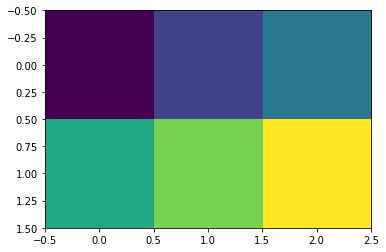

In [9]:
from matplotlib import pyplot as plt

plt.imshow(np.squeeze(array_test[:, :, 0]))

## Organizar archivos:

In [10]:
ruta = "G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Real/"

In [11]:
# Definimos las rutas a los folders:
folder_paths = {
    "CT-0": ruta + "CT-0",
    #"CT-1": ruta + "G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Real/CT-1",
    "CT-2": ruta + "CT-2",
    "CT-3": ruta + "CT-3"
}

# Definimos la proporción para dividir las imagenes: 
train_ratio = 0.7  # 70% para training
test_ratio = 0.2   # 20% para testing
valid_ratio = 0.1  # 10% para validation

# Inicializamos los diccionarios para almacenar las rutas de los sets de training, test y validation.
train_data = []
test_data = []
valid_data = []

# Asignamos las etiquetas a las carpetas. 
label_mapping = {
    "CT-0": 0,
    #"CT-1": 1,
    "CT-2": 1,
    "CT-3": 1
}


# Iteramos sobre cada uno de los folders y mapeamos las rutas de los archivos. 
for folder_name, folder_path in folder_paths.items():
    file_list = os.listdir(folder_path)
    random.seed(941130)
    random.shuffle(file_list)  # 'Barajamos' la lista de archivos de forma aleatoria. 

    # Dividimos la lista de archivos en los sets de training, test y validation.
    num_files = len(file_list)
    train_end = int(train_ratio * num_files)
    test_end = train_end + int(test_ratio * num_files)

    train_files = file_list[:train_end]
    test_files = file_list[train_end:test_end]
    valid_files = file_list[test_end:]


    # Asignamos etiquetas a los archivos y las guardamos en su respectiva lista. 
    if folder_name == "CT-0":
        train_data.extend([(os.path.join(folder_path, file_name), label_mapping[folder_name]) for file_name in train_files])
        test_data.extend([(os.path.join(folder_path, file_name), label_mapping[folder_name]) for file_name in test_files])
        valid_data.extend([(os.path.join(folder_path, file_name), label_mapping[folder_name]) for file_name in valid_files])
    else:
        train_data.extend([(os.path.join(folder_path, file_name), label_mapping[folder_name]) for file_name in train_files])
        test_data.extend([(os.path.join(folder_path, file_name), label_mapping[folder_name]) for file_name in test_files])
        valid_data.extend([(os.path.join(folder_path, file_name), label_mapping[folder_name]) for file_name in valid_files])

# Create DataFrames from the lists
train_df = pd.DataFrame(train_data, columns=["File_Path", "Label"])
test_df = pd.DataFrame(test_data, columns=["File_Path", "Label"])
valid_df = pd.DataFrame(valid_data, columns=["File_Path", "Label"])

# Creamos las rutas para cuando trabajamos en google
train_df['File_Path_Google'] = train_df['File_Path'].str.replace('G:/Mi unidad/Maestria/','/content/gdrive/MyDrive/Maestria/')
test_df['File_Path_Google'] = test_df['File_Path'].str.replace('G:/Mi unidad/Maestria/','/content/gdrive/MyDrive/Maestria/')
valid_df['File_Path_Google'] = valid_df['File_Path'].str.replace('G:/Mi unidad/Maestria/','/content/gdrive/MyDrive/Maestria/')

train_df['File_Path_Google'] = train_df['File_Path_Google'].str.replace('\\','/', regex=True)
test_df['File_Path_Google'] = test_df['File_Path_Google'].str.replace('\\','/', regex=True)
valid_df['File_Path_Google'] = valid_df['File_Path_Google'].str.replace('\\','/', regex=True)

train_df['File_Path'] = train_df['File_Path'].str.replace('\\','/', regex=True)
test_df['File_Path'] = test_df['File_Path'].str.replace('\\','/', regex=True)
valid_df['File_Path'] = valid_df['File_Path'].str.replace('\\','/', regex=True)

# Ordenamos columnas 
train_df = train_df[['File_Path','File_Path_Google','Label']]
test_df = test_df[['File_Path','File_Path_Google','Label']]
valid_df = valid_df[['File_Path','File_Path_Google','Label']]

# Imprimimos las etiquetas mapeadas
print("Label Mapping:")
for folder_name, label in label_mapping.items():
    print(f"{folder_name}: {label}")


Label Mapping:
CT-0: 0
CT-2: 1
CT-3: 1


In [12]:
print("\nTraining DataFrame:")
train_df


Training DataFrame:


,File_Path,File_Path_Google,Label
0,G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0053.nii.gz,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0053.nii.gz,0
1,G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0195.nii.gz,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0195.nii.gz,0
2,G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0010.nii.gz,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0010.nii.gz,0
3,G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0009.nii.gz,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0009.nii.gz,0
4,G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0050.nii.gz,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0050.nii.gz,0
...,...,...,...
290,G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Real/CT-3/study_1089.nii.gz,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-3/study_1089.nii.gz,1
291,G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Real/CT-3/study_1068.nii.gz,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-3/study_1068.nii.gz,1
292,G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Real/CT-3/study_1104.nii.gz,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-3/study_1104.nii.gz,1
293,G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Real/CT-3/study_1072.nii.gz,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-3/study_1072.nii.gz,1


In [13]:
print("\nTest DataFrame:")
test_df


Test DataFrame:


,File_Path,File_Path_Google,Label
0,G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0094.nii.gz,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0094.nii.gz,0
1,G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0151.nii.gz,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0151.nii.gz,0
2,G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0210.nii.gz,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0210.nii.gz,0
3,G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0011.nii.gz,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0011.nii.gz,0
4,G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0205.nii.gz,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0205.nii.gz,0
...,...,...,...
79,G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Real/CT-3/study_1096.nii.gz,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-3/study_1096.nii.gz,1
80,G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Real/CT-3/study_1088.nii.gz,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-3/study_1088.nii.gz,1
81,G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Real/CT-3/study_1069.nii.gz,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-3/study_1069.nii.gz,1
82,G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Real/CT-3/study_1106.nii.gz,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-3/study_1106.nii.gz,1


In [14]:
print("\nValidation DataFrame:")
valid_df


Validation DataFrame:


,File_Path,File_Path_Google,Label
0,G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0026.nii.gz,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0026.nii.gz,0
1,G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0031.nii.gz,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0031.nii.gz,0
2,G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0180.nii.gz,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0180.nii.gz,0
3,G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0075.nii.gz,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0075.nii.gz,0
4,G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0139.nii.gz,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0139.nii.gz,0
5,G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0100.nii.gz,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0100.nii.gz,0
6,G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0092.nii.gz,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0092.nii.gz,0
7,G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0114.nii.gz,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0114.nii.gz,0
8,G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0243.nii.gz,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0243.nii.gz,0
9,G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0178.nii.gz,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0178.nii.gz,0


In [15]:
valid_df.Label.value_counts()

0    27
1    18
Name: Label, dtype: int64

In [16]:
print(f"Revisión Etiquetas Set Entrenamiento: {Counter(train_df.Label)}")
print(f"Revisión Etiquetas Set Entrenamiento: {Counter(test_df.Label)}")
print(f"Revisión Etiquetas Set Entrenamiento: {Counter(valid_df.Label)}")


Revisión Etiquetas Set Entrenamiento: Counter({0: 177, 1: 118})
Revisión Etiquetas Set Entrenamiento: Counter({0: 50, 1: 34})
Revisión Etiquetas Set Entrenamiento: Counter({0: 27, 1: 18})


## Exportando DFs con rutas y etiquetas

In [17]:
train_df.to_csv(r'G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Path_Sets/train_df.csv',index=False)
test_df.to_csv(r'G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Path_Sets/test_df.csv',index=False)
valid_df.to_csv(r'G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Path_Sets/valid_df.csv',index=False)
print("Exportado")

Exportado
